<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/example_lstm_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf


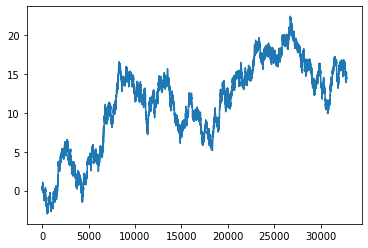

In [2]:
gaussian_data = np.random.normal(size=32768)
random_walk_data = np.cumsum(gaussian_data) / 10.0

plt.plot(random_walk_data)


In [3]:
WINDOW_SIZE = 32


def slice_dataset(data, window_size=32):
    inputs = []
    outputs = []

    for idx in range(window_size, len(data)):
        inputs.append(data[(idx - window_size): idx])
        outputs.append(data[idx])

    inputs = np.array(inputs)
    outputs = np.array(outputs)

    return inputs, outputs


inputs, outputs = slice_dataset(random_walk_data, WINDOW_SIZE)

print(f"inputs.shape: {inputs.shape} outputs.shape: {outputs.shape}")


inputs.shape: (32736, 32) outputs.shape: (32736,)


In [4]:
BATCH_SIZE = 64


def create_tf_dataset(inputs, outputs):
    # The LSTM network expects the input data (X) to be provided with a specific
    # array structure in the form of: [samples, time steps, features].
    inputs = np.expand_dims(inputs, axis=2)
    outputs = np.expand_dims(outputs, axis=1)

    return tf.data.Dataset.from_tensor_slices((inputs, outputs))


dataset = create_tf_dataset(inputs, outputs)
dataset = dataset.shuffle(buffer_size=256).batch(BATCH_SIZE)

batch = next(iter(dataset.take(1)))
inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (64, 32, 1)
Target shape: (64, 1)


In [ ]:
LR = 1e-3
N_EPOCHS = 20

model = keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(WINDOW_SIZE, 1)),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=LR), loss="mse")
model.summary()

history = model.fit(
    dataset,
    epochs=N_EPOCHS,
)

plt.title("training mse")
plt.plot(history.history["loss"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
512/512 [==============================] - 10s 8ms/step - loss: 10.9369
Epoch 2/20
512/512 [==============================] - 4s 8ms/step - loss: 2.6335
Epoch 3/20
512/512 [==============================] - 4s 8ms/step - loss: 0.9754
Epoch 4/20
512/512 [==============================] - 4s 8ms/step - loss: 0.3617
Epoch 5/20
157/512 [========>.....................] - ETA: 3s - loss: 0.0445

In [ ]:
def predict_all(inputs, model, window_size):
    outputs = [0] * window_size
    predictions = model(np.expand_dims(inputs, axis=2))
    predictions = np.squeeze(predictions)
    outputs = outputs + list(predictions)
    return outputs


predictions = predict_all(inputs, model, WINDOW_SIZE)
plt.plot(random_walk_data)
plt.plot(predictions)
plt.legend(["groundtruth", "predictions"])
